<a href="https://colab.research.google.com/github/Zainab200064745/final-year-project-code/blob/main/multivariateGaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Year Project


   9324  5428
0  9544  5500
1  9220  5400
2  9012  5432
3  9296  5472
4  9192  5820
Index(['9324', '5428'], dtype='object')


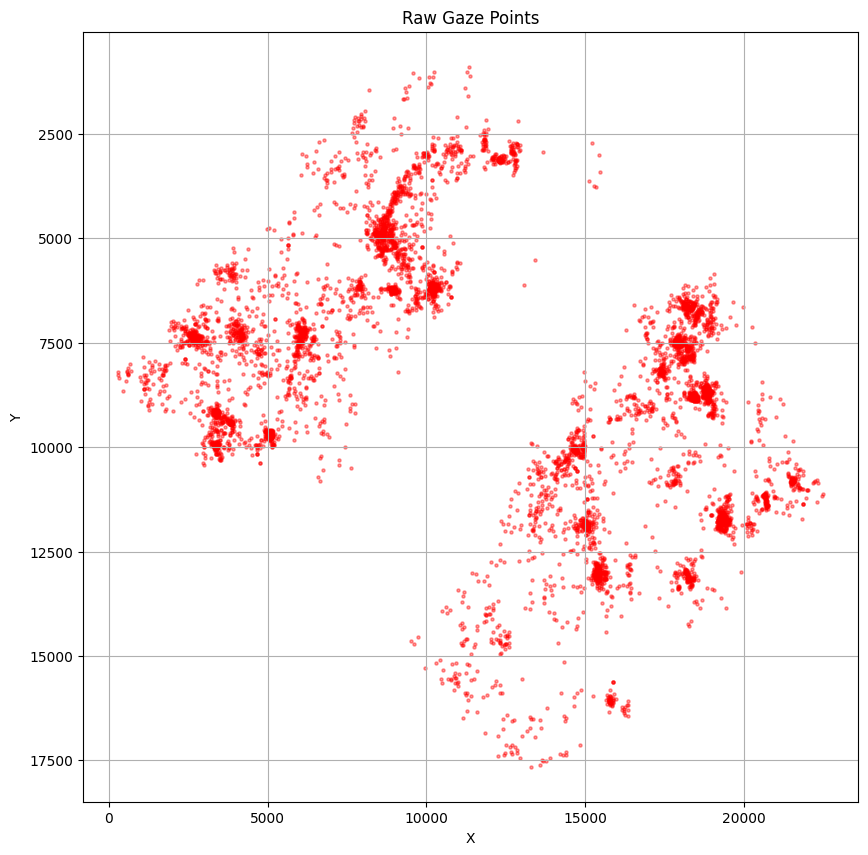

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


# load gaze from CSV file
df = pd.read_csv("/Level 15.csv")

# Show sample
print(df.head())

# Scatter plot of gaze points
plt.figure(figsize=(10, 10))
print(df.columns)
plt.scatter( df['9324'], df['5428'], s=5, alpha=0.4, c='red')
plt.title("Raw Gaze Points")
plt.gca().invert_yaxis()  # y-axis in images is usually inverted
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


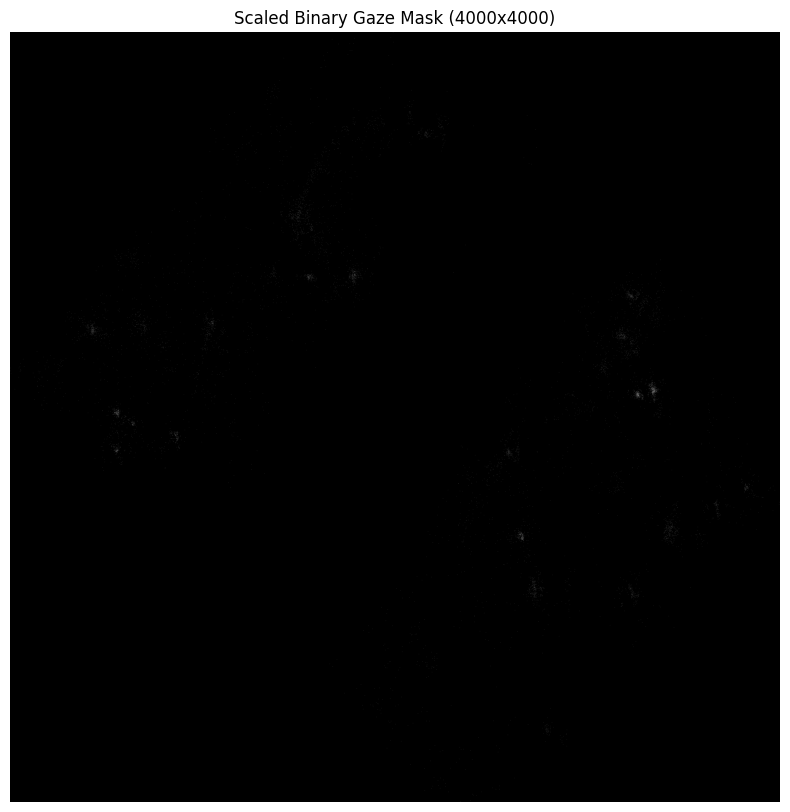

X_scaled min/max: 0 3999
Y_scaled min/max: 0 3999
Activated pixels (sum): 6555
Number of gaze points: 6803
Sample gaze points:
    9324  5428
0  9544  5500
1  9220  5400
2  9012  5432
3  9296  5472
4  9192  5820
Min/max X: 298 22501
Min/max Y: 892 17652
Binary mask saved at: binary_gaze_mask.png


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

#  mask dimensions from WSI
W_target, H_target = 4000, 4000

# coordinate columns
x_vals = df['9324'].values
y_vals = df['5428'].values

# Normalize to 0–1
x_norm = (x_vals - x_vals.min()) / (x_vals.max() - x_vals.min())
y_norm = (y_vals - y_vals.min()) / (y_vals.max() - y_vals.min())

# Scale to WSI dimensions
x_scaled = (x_norm * (W_target - 1)).astype(int)
y_scaled = (y_norm * (H_target - 1)).astype(int)

# Create binary mask
binary_mask = np.zeros((H_target, W_target), dtype=np.uint8)

for x, y in zip(x_scaled, y_scaled):
    binary_mask[y, x] = 1  # (row, col) = (y, x)

plt.figure(figsize=(10, 10))
plt.imshow(binary_mask, cmap='gray')
plt.title("Scaled Binary Gaze Mask (4000x4000)")
plt.axis('off')
plt.show()

print("X_scaled min/max:", x_scaled.min(), x_scaled.max())
print("Y_scaled min/max:", y_scaled.min(), y_scaled.max())
print("Activated pixels (sum):", np.sum(binary_mask))


# Check number of gaze points
print("Number of gaze points:", len(df))

# Check first few values
print("Sample gaze points:\n", df[['9324', '5428']].head())

# Check bounds of values
print("Min/max X:", df['9324'].min(), df['9324'].max())
print("Min/max Y:", df['5428'].min(), df['5428'].max())

binary_mask = binary_mask * 255

# Save the binary mask as a PNG file
save_path = "binary_gaze_mask.png"  # Save in the current directory
image = Image.fromarray(binary_mask)
image.save(save_path)



print(f"Binary mask saved at: {save_path}")


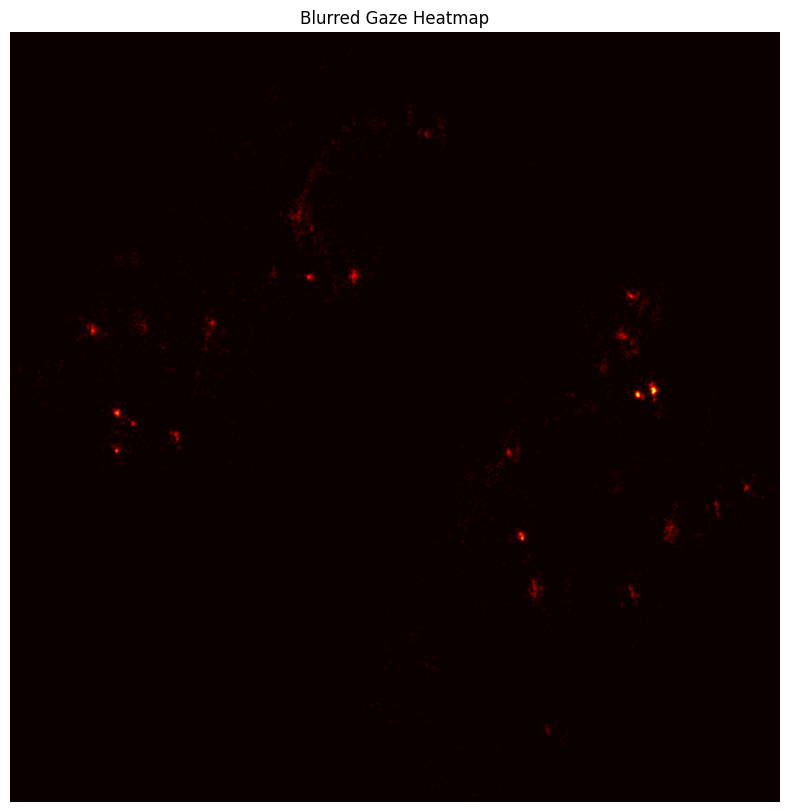

In [6]:
import cv2

# Apply Gaussian blur
binary_mask_blurred = cv2.GaussianBlur(binary_mask.astype(np.float32), (25, 25), 0)


plt.figure(figsize=(10, 10))
plt.imshow(binary_mask_blurred, cmap='hot')
plt.title("Blurred Gaze Heatmap")
plt.axis('off')
plt.show()


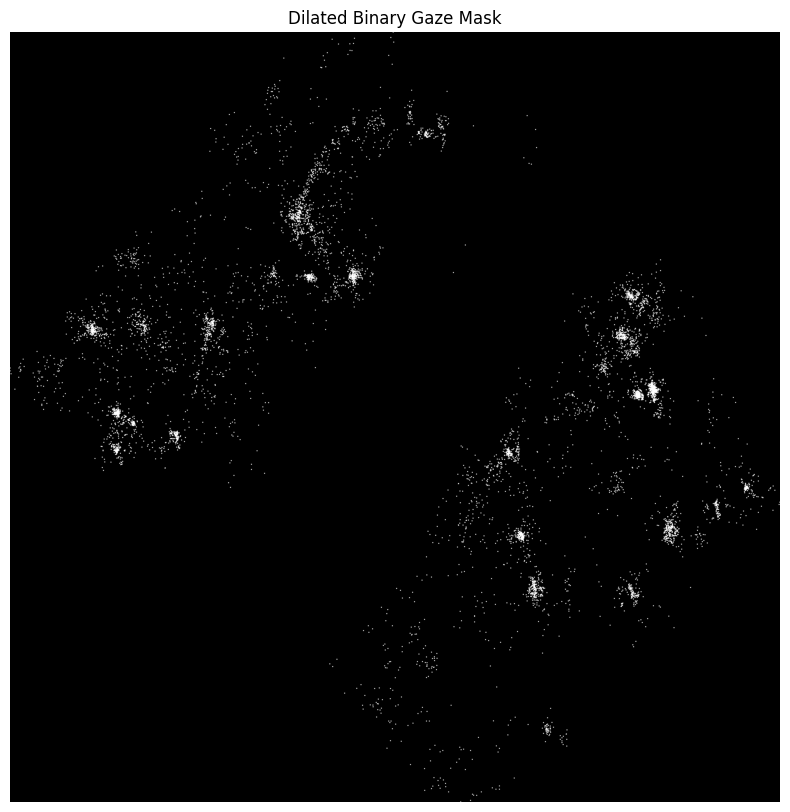

In [8]:
kernel = np.ones((5, 5), np.uint8)
dilated_mask = cv2.dilate(binary_mask, kernel, iterations=1)

plt.figure(figsize=(10, 10))
plt.imshow(dilated_mask, cmap='gray')
plt.title("Dilated Binary Gaze Mask")
plt.axis('off')
plt.show()

Heatmap saved as raw_gaze_heatmap.png


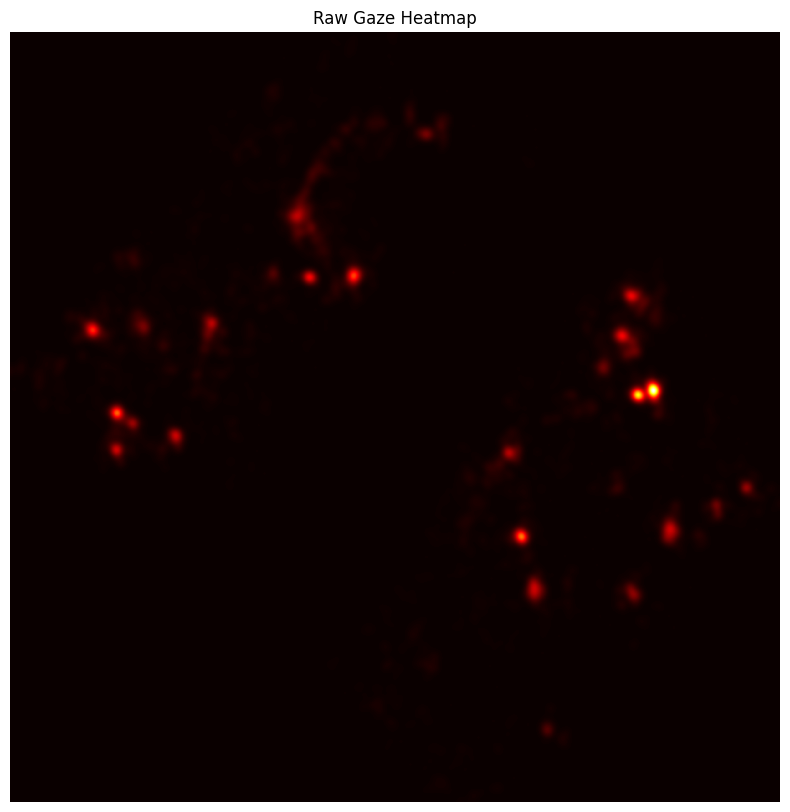

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image
import pandas as pd

file_path = ("/Level 15.csv")
df = pd.read_csv(file_path)

# mask dimensions
W_target, H_target = 4000, 4000

# gaze coordinate columns
x_vals = df['9324'].values
y_vals = df['5428'].values

# Normalize to 0–1
x_norm = (x_vals - x_vals.min()) / (x_vals.max() - x_vals.min())
y_norm = (y_vals - y_vals.min()) / (y_vals.max() - y_vals.min())

# Scale to WSI dimensions
x_scaled = (x_norm * (W_target - 1)).astype(int)
y_scaled = (y_norm * (H_target - 1)).astype(int)

# Create Heatmap from Raw Gaze Points
def generate_gaze_heatmap(x_scaled, y_scaled, image_shape=(4000, 4000), sigma=20):
    heatmap = np.zeros(image_shape, dtype=np.float32)
    for x, y in zip(x_scaled, y_scaled):
        if 0 <= x < image_shape[1] and 0 <= y < image_shape[0]:
            heatmap[y, x] += 1
    # Apply Gaussian smoothing for realistic heatmap
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    # Normalize the heatmap to range [0, 1]
    heatmap /= heatmap.max()
    return heatmap

# Generate the gaze heatmap
raw_gaze_heatmap = generate_gaze_heatmap(x_scaled, y_scaled)

#  Save the Heatmap as a PNG file
heatmap_image = (raw_gaze_heatmap * 255).astype(np.uint8)  # Convert to 0-255 for saving
heatmap_image = Image.fromarray(heatmap_image)
heatmap_image.save("raw_gaze_heatmap.png")
print("Heatmap saved as raw_gaze_heatmap.png")

# Step 3: Visualize the Heatmap
plt.figure(figsize=(10, 10))
plt.imshow(raw_gaze_heatmap, cmap='hot', interpolation='nearest')
plt.title("Raw Gaze Heatmap")
plt.axis('off')
plt.show()


In [10]:
import numpy as np

# Get real gaze coordinates
X_real = df[['9324', '5428']].values  # shape (N, 2)

# Center the data (important for covariance)
X_centered = X_real - X_real.mean(axis=0)

# Compute empirical covariance matrix
cov_matrix = np.cov(X_centered.T)

print("Covariance matrix:\n", cov_matrix)

Covariance matrix:
 [[35249101.91089818  5911037.08371959]
 [ 5911037.08371959  8585478.62403467]]


In [11]:
mean_point = X_real.mean(axis=0)
num_samples = len(X_real)

# Sample from multivariate Gaussian
synthetic_points = np.random.multivariate_normal(mean=mean_point, cov=cov_matrix, size=num_samples)

In [12]:
mean_point = df[['9324', '5428']].mean().values
synthetic_points = np.random.multivariate_normal(mean=mean_point, cov=cov_matrix, size=6555)

In [13]:

W, H = 4000, 4000
synthetic_points = np.clip(synthetic_points, [0, 0], [W-1, H-1]).astype(int)

# Create binary mask
synthetic_mask = np.zeros((H, W), dtype=np.uint8)
for x, y in synthetic_points:
    synthetic_mask[y, x] = 1



In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Mean near center of image
mean = [2000, 2000]

# Reasonable variances to avoid overflow
cov_matrix = np.array([[300_000, 0], [0, 3_000_000]])  # Still more spread in Y

# Generate synthetic gaze points
synthetic_points = np.random.multivariate_normal(mean, cov_matrix, size=6555)

# Clip points to stay within image
synthetic_points = np.clip(synthetic_points, [0, 0], [3999, 3999]).astype(int)

# Check a few values
print("First 5 points:\n", synthetic_points[:5])
print("Unique Y values:", np.unique(synthetic_points[:, 1]).shape[0])

First 5 points:
 [[2647 3999]
 [ 799 2409]
 [2121 3999]
 [2026    0]
 [1329  997]]
Unique Y values: 2757


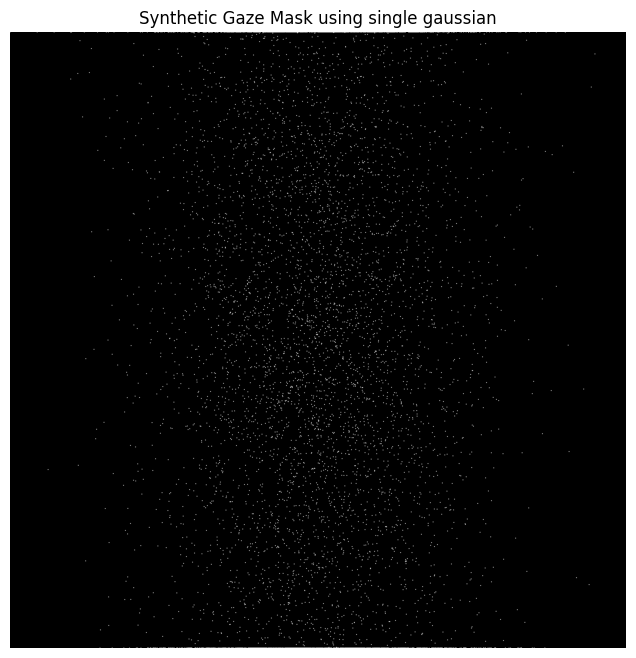

In [15]:
# Binary mask
mask = np.zeros((4000, 4000), dtype=np.uint8)
for x, y in synthetic_points:
    mask[y, x] = 1

# Dilate for visibility
import cv2
mask_dilated = cv2.dilate(mask, np.ones((5,5), np.uint8), iterations=1)

plt.figure(figsize=(8, 8))
plt.imshow(mask_dilated, cmap='gray')
plt.title("Synthetic Gaze Mask using single gaussian")
plt.axis('off')
plt.show()

In [16]:
import cv2
import numpy as np

# Scale binary mask to 0–255 for image saving
binary_mask_img = (binary_mask * 255).astype(np.uint8)

# Save as PNG
cv2.imwrite("binary_mask.png", binary_mask_img)

# Save as NPY
np.save("binary_mask.npy", binary_mask)


<ipython-input-17-4ee340d38150>:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


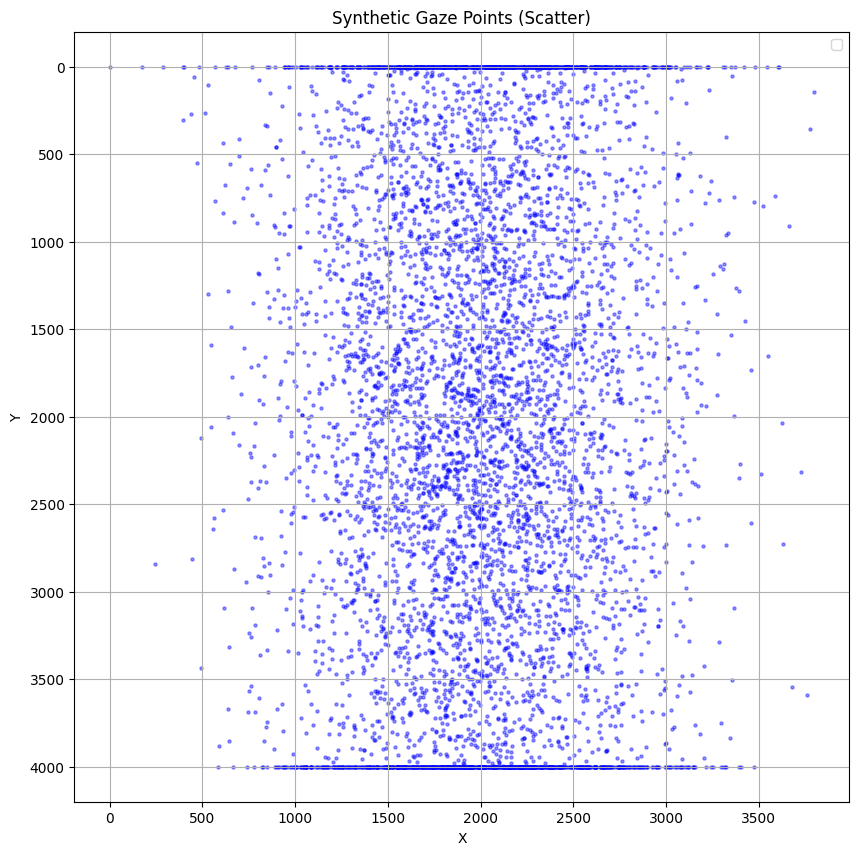

In [17]:
import matplotlib.pyplot as plt



plt.figure(figsize=(10, 10))
plt.scatter(synthetic_points[:, 0], synthetic_points[:, 1], s=5, alpha=0.4, color='blue')
plt.gca().invert_yaxis()
plt.title("Synthetic Gaze Points (Scatter)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.show()

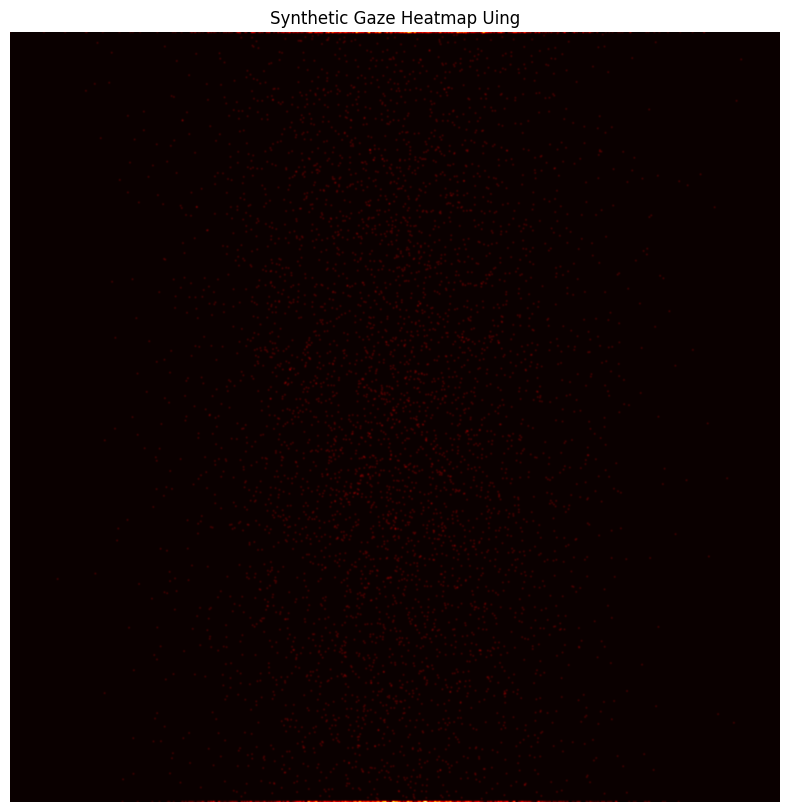

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Create blank mask
heatmap_base = np.zeros((4000, 4000), dtype=np.float32)

# Add 1 at each gaze point location
for x, y in synthetic_points:
    if 0 <= x < 4000 and 0 <= y < 4000:
        heatmap_base[y, x] += 1  # Note: row = y, col = x




# Apply blur — (25, 25) is the kernel size (spread), can be tweaked
blurred_heatmap = cv2.GaussianBlur(heatmap_base, (25, 25), 0)



plt.figure(figsize=(10, 10))
plt.imshow(blurred_heatmap, cmap='hot')  # You can also try 'jet' or 'viridis'
plt.title("Synthetic Gaze Heatmap Uing")
plt.axis('off')
plt.show()



In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Step 1: Create binary masks from gaze points
real_mask = np.zeros((4000, 4000), dtype=np.float32)
synthetic_mask = np.zeros((4000, 4000), dtype=np.float32)

# Fill real mask
for x, y in df[['9324', '5428']].astype(int).values:
    if 0 <= x < 4000 and 0 <= y < 4000:
        real_mask[y, x] += 1

# Fill synthetic mask
for x, y in synthetic_points:
    if 0 <= x < 4000 and 0 <= y < 4000:
        synthetic_mask[y, x] += 1

# Step 2: Apply Gaussian blur
real_heatmap = cv2.GaussianBlur(real_mask, (25, 25), 0)
synthetic_heatmap = cv2.GaussianBlur(synthetic_mask, (25, 25), 0)

# Step 3: Normalize heatmaps
if real_heatmap.max() > 0:
    real_heatmap = real_heatmap / real_heatmap.max()

if synthetic_heatmap.max() > 0:
    synthetic_heatmap = synthetic_heatmap / synthetic_heatmap.max()


In [20]:
# Make sure both masks are the same size
assert binary_mask.shape == mask.shape, "Masks must be the same size for IoU"

# Compute IoU
intersection = np.logical_and(binary_mask, mask).sum()
union = np.logical_or(binary_mask, mask).sum()
iou = intersection / union if union != 0 else 0.0

print(f"IoU between real and synthetic masks: {round(iou, 4)}")

IoU between real and synthetic masks: 0.0002


In [21]:
intersection = np.logical_and(dilated_mask, mask).sum()
union = np.logical_or(dilated_mask, mask).sum()
iou_dilated = intersection / union if union != 0 else 0.0

print(f"IoU (with dilated real mask): {round(iou_dilated, 4)}")

IoU (with dilated real mask): 0.0004


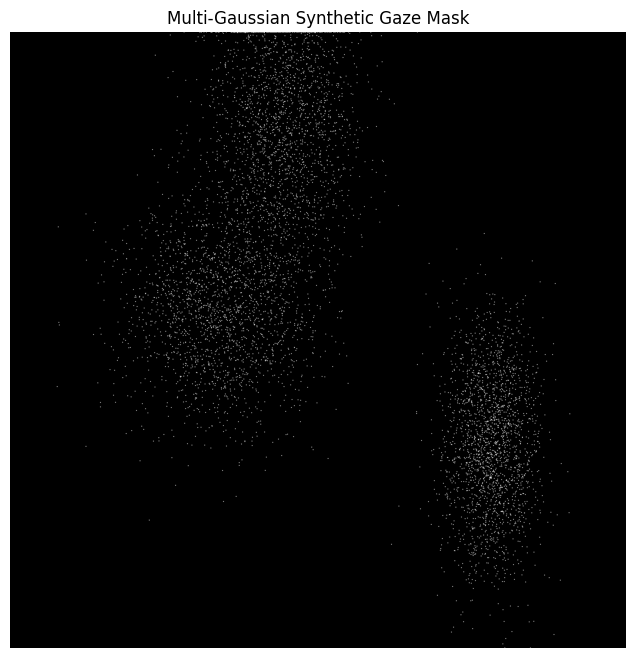

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import cv2


image_shape = (4000, 4000)  # (height, width)
n_points = 6000             # Total number of synthetic gaze points
n_blobs = 3                 # Number of Gaussian blobs

# Set a fixed random seed for reproducibility
np.random.seed(42)

#  Generate Multi-Gaussian Gaze Points
def generate_multi_gaussian_gaze(n_points=6000, image_size=(4000, 4000), n_blobs=3):
    width, height = image_size
    points = []

    for _ in range(n_blobs):
        # Random mean within safe bounds
        mean = np.random.randint(500, min(width, height) - 500, size=2)

        # Random covariance values with fixed seed
        cov_x = np.random.randint(20_000, 100_000)
        cov_y = np.random.randint(100_000, 300_000)
        cov_matrix = np.array([[cov_x, 0], [0, cov_y]])


        # Sample points with fixed seed
        blob = np.random.multivariate_normal(mean, cov_matrix, size=n_points // n_blobs)
        points.append(blob)

    all_points = np.vstack(points)
    all_points = np.clip(all_points, [0, 0], np.array(image_size) - 1).astype(int)
    return all_points

synthetic_points = generate_multi_gaussian_gaze(n_points, (4000, 4000), n_blobs)

# Create Binary Mask from Synthetic Points ---
synthetic_mask = np.zeros(image_shape, dtype=np.uint8)
for x, y in synthetic_points:
    synthetic_mask[y, x] = 1  # Note: (row, col) = (y, x)

# Dilate for visual realism
kernel = np.ones((5, 5), np.uint8)
synthetic_mask = cv2.dilate(synthetic_mask, kernel, iterations=1)

# --- Step 3: Visualize ---
plt.figure(figsize=(8, 8))
plt.imshow(synthetic_mask, cmap='gray')
plt.title("Multi-Gaussian Synthetic Gaze Mask")
plt.axis('off')
plt.show()

In [ ]:
intersection = np.logical_and(dilated_mask, synthetic_mask).sum()
union = np.logical_or(dilated_mask, synthetic_mask).sum()
iou = intersection / union if union != 0 else 0.0

print(f"IoU (Multi-Gaussian): {round(iou, 4)}")

IoU (Multi-Gaussian): 0.0087


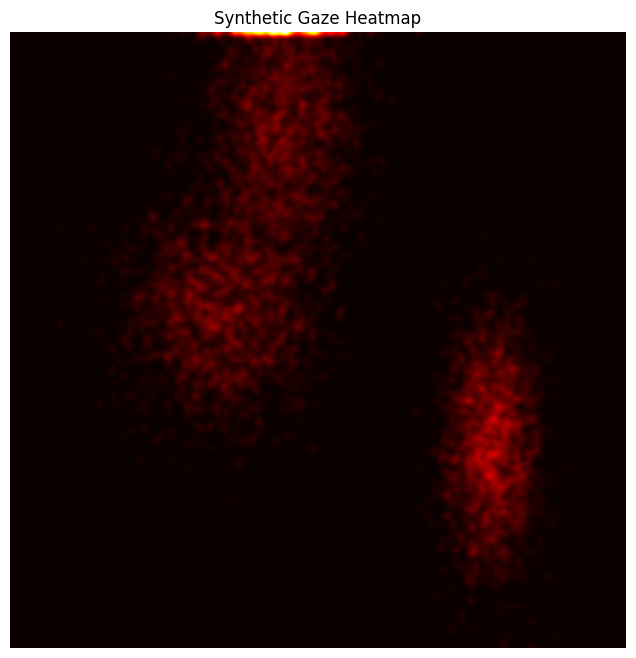

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

#  Parameters
image_shape = (4000, 4000)
n_points = 6000             # number of synthetic gaze points
n_blobs = 3                 # Number of Gaussian blobs

# Set a fixed random seed for reproducibility
np.random.seed(42)

# --- Step 1: Generate Multi-Gaussian Gaze Points ---
def generate_multi_gaussian_gaze(n_points=6000, image_size=(4000, 4000), n_blobs=3):
    width, height = image_size
    points = []

    for _ in range(n_blobs):
        # Random mean within safe bounds
        mean = np.random.randint(500, min(width, height) - 500, size=2)

        # Random covariance values with fixed seed
        cov_x = np.random.randint(20_000, 100_000)
        cov_y = np.random.randint(100_000, 300_000)
        cov_matrix = np.array([[cov_x, 0], [0, cov_y]])

        # Sample points with fixed seed
        blob = np.random.multivariate_normal(mean, cov_matrix, size=n_points // n_blobs)
        points.append(blob)

    all_points = np.vstack(points)
    all_points = np.clip(all_points, [0, 0], np.array(image_size) - 1).astype(int)
    return all_points

synthetic_points = generate_multi_gaussian_gaze(n_points, (4000, 4000), n_blobs)

# --- Step 2: Create Heatmap from Synthetic Points ---
def generate_heatmap(points, image_shape=(4000, 4000), sigma=20):
    heatmap = np.zeros(image_shape, dtype=np.float32)
    for x, y in points:
        if 0 <= x < image_shape[1] and 0 <= y < image_shape[0]:
            heatmap[y, x] += 1
    # Apply Gaussian smoothing for realistic heatmap
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    # Normalize the heatmap to range
    heatmap /= heatmap.max()
    return heatmap

synthetic_heatmap = generate_heatmap(synthetic_points)

# Step 3: Visualize the Heatmap
plt.figure(figsize=(8, 8))
plt.imshow(synthetic_heatmap, cmap='hot', interpolation='nearest')
plt.title("Synthetic Gaze Heatmap")
plt.axis('off')
plt.show()


In [31]:
from scipy.stats import entropy, pearsonr
import numpy as np

# KL Divergence Calculation Function
def calculate_kl_heatmaps(heatmap1, heatmap2):

    # Step 1: Flatten the heatmaps to 1D arrays
    p = heatmap1.flatten() + 1e-10  # Adding small value to avoid log(0)
    q = heatmap2.flatten() + 1e-10

    # Step 2: Normalize the distributions to sum to 1
    p /= np.sum(p)
    q /= np.sum(q)

    # Step 3: Calculate KL Divergence
    kl_div = entropy(p, q)
    return kl_div

# Pearson Correlation Calculation Function
def calculate_pearson(heatmap1, heatmap2):

    x = heatmap1.flatten()
    y = heatmap2.flatten()
    correlation, _ = pearsonr(x, y)
    return correlation

# Calculating KL Divergence and Pearson Correlation
kl_divergence = calculate_kl_heatmaps(raw_gaze_heatmap, synthetic_heatmap)
pearson_corr = calculate_pearson(raw_gaze_heatmap, synthetic_heatmap)

print(f"KL Divergence: {kl_divergence:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")


KL Divergence: 16.8735
Pearson Correlation: -0.0070


In [32]:
print("Activated pixels:", np.sum(synthetic_mask))

Activated pixels: 142932


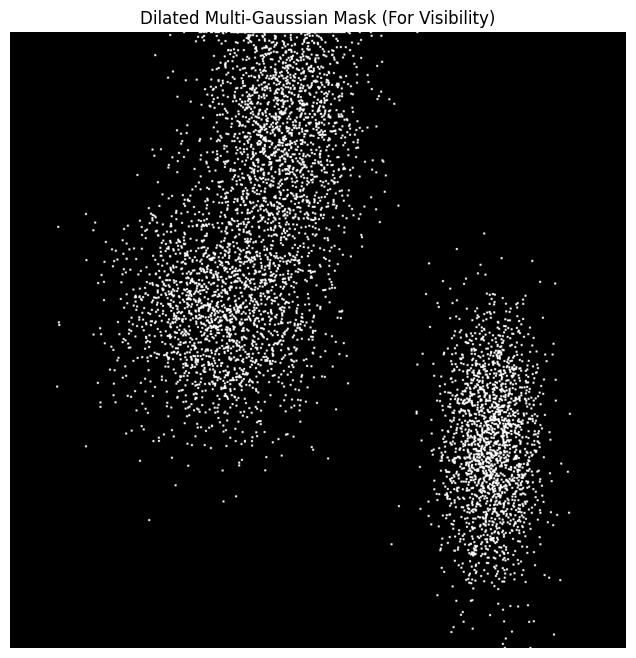

In [33]:
import cv2

kernel = np.ones((9, 9), np.uint8)  # Larger = more visible
synthetic_mask_dilated = cv2.dilate(synthetic_mask, kernel, iterations=1)

plt.figure(figsize=(8, 8))
plt.imshow(synthetic_mask_dilated, cmap='gray')
plt.title("Dilated Multi-Gaussian Mask (For Visibility)")
plt.axis('off')
plt.show()

In [34]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Load real gaze data
df = pd.read_csv("/Level 15.csv", header=None)
df.columns = ['9324', '5428']
real_coords = df[['9324', '5428']].values

# Cluster real fixation points
kmeans = KMeans(n_clusters=3, random_state=0).fit(real_coords)
centers = kmeans.cluster_centers_

print("Cluster centers:")
print(centers)


Cluster centers:
[[14925.05199699 12523.43556895]
 [ 6652.63713851  6634.85449011]
 [18706.04790146  8883.29516423]]


In [29]:
print("Real heatmap sum:", np.sum(real_heatmap))
print("Synthetic heatmap sum:", np.sum(synthetic_heatmap))
print("Real heatmap max:", np.max(real_heatmap))
print("Synthetic heatmap max:", np.max(synthetic_heatmap))

Real heatmap sum: 0.0
Synthetic heatmap sum: 43706.043
Real heatmap max: 0.0
Synthetic heatmap max: 1.0


In [ ]:
real_cov = np.cov(real_coords.T)
print("Real gaze covariance matrix:\n", real_cov)


Real gaze covariance matrix:
 [[35245093.94247989  5911447.33574257]
 [ 5911447.33574257  8585610.9724714 ]]
